In [4]:
import torch
from torchdrug import data, datasets
%matplotlib inline

# Datasets

In [2]:
dataset = datasets.ClinTox(".cache/molecule-datasets/")
lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]
lengths += [len(dataset) - sum(lengths)]
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, lengths)

15:26:36   Downloading http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/clintox.csv.gz to .cache/molecule-datasets/clintox.csv.gz
15:26:37   Extracting .cache/molecule-datasets/clintox.csv.gz to .cache/molecule-datasets/clintox.csv


Constructing molecules from SMILES:   0%|          | 0/1484 [00:00<?, ?it/s]/home/seeyou/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `*`
  warnings.warn("Unknown value `%s`" % x)
RDKit ERROR: [15:26:37] Explicit valence for atom # 0 N, 5, is greater than permitted
/home/seeyou/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Tc`
  warnings.warn("Unknown value `%s`" % x)
[15:26:37] Explicit valence for atom # 0 N, 5, is greater than permitted
/home/seeyou/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Fe`
  warnings.warn("Unknown value `%s`" % x)
/home/seeyou/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:   6%|▌         | 85/1484 [00:00<00:01, 845.64it/s]/home/seeyou/anacond

/home/seeyou/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/molecule.py:858: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


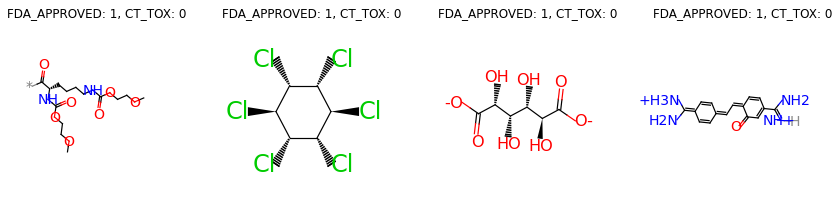

In [5]:
graphs = []
labels = []
for i in range(4):
    sample = dataset[i]
    graphs.append(sample.pop("graph"))
    label = ["%s: %d" % (k, v) for k, v in sample.items()]
    label = ", ".join(label)
    labels.append(label)
graph = data.Molecule.pack(graphs)
graph.visualize(labels, num_row=1)

# Model

In [6]:
from torchdrug import core, models, tasks, utils

model = models.GIN(input_dim=dataset.node_feature_dim,
                   hidden_dims=[256, 256, 256, 256],
                   short_cut=True, batch_norm=True, concat_hidden=True)
task = tasks.PropertyPrediction(model, task=dataset.tasks,
                                criterion="bce", metric=("auprc", "auroc"))

# Train and Test

In [7]:
optimizer = torch.optim.Adam(task.parameters(), lr=1e-3)
solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
                     gpus=[0], batch_size=1024)
solver.train(num_epoch=100)
solver.evaluate("valid")

15:28:16   Preprocess training set
15:28:17   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:28:17   Epoch 0 begin
15:28:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:28:18   binary cross entropy: 1.27319
15:28:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:28:18   Epoch 0 end
15:28:18   duration: 2.08 secs
15:28:18   speed: 0.96 batch / sec
15:28:18   ETA: 3.42 mins
15:28:18   max GPU memory: 727.3 MiB
15:28:18   ------------------------------
15:28:18   average binary cross entropy: 3.92402
15:28:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:28:18   Epoch 1 begin
15:28:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:28:18   Epoch 1 end
15:28:18   duration: 0.11 secs
15:28:18   speed: 17.40 batch / sec
15:28:18   ETA: 1.79 mins
15:28:18   max GPU memory: 732.4 MiB
15:28:18   ------------------------------
15:28:18   average binary cross entropy: 3.50622
15:28:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:28:18   Epoch 2 begin
15:28:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
15:28:18   Epoch 2 end
15:28:18   duration: 0.11 secs
15:28:18   spe

{'auprc [FDA_APPROVED]': tensor(0.9851, device='cuda:0'),
 'auprc [CT_TOX]': tensor(0.2737, device='cuda:0'),
 'auroc [FDA_APPROVED]': tensor(0.8013, device='cuda:0'),
 'auroc [CT_TOX]': tensor(0.6651, device='cuda:0')}

/home/seeyou/anaconda3/envs/drug/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/seeyou/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/molecule.py:858: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


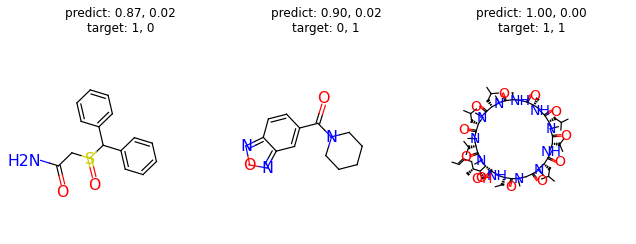

In [8]:
from torch.nn import functional as F

samples = []
categories = set()
for sample in valid_set:
    category = tuple([v for k, v in sample.items() if k != "graph"])
    if category not in categories:
        categories.add(category)
        samples.append(sample)
samples = data.graph_collate(samples)
samples = utils.cuda(samples)

preds = F.sigmoid(task.predict(samples))
targets = task.target(samples)

titles = []
for pred, target in zip(preds, targets):
    pred = ", ".join(["%.2f" % p for p in pred])
    target = ", ".join(["%d" % t for t in target])
    titles.append("predict: %s\ntarget: %s" % (pred, target))
graph = samples["graph"]
graph.visualize(titles, figure_size=(3, 3.5), num_row=1)